# Visualize network activations during inference

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IPython.display import HTML

from yolo.models import ResNetBackbone, YOLOv1

DEVICE = "cpu"
activations = {}


def hook_fn(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu()

    return hook


def register_hooks(model):
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            layer.register_forward_hook(hook_fn(name))


def load_model(
    checkpoint_path: str,
    num_classes: int = 20,
    freeze_backbone: bool = False,
    device: str = "cuda",
) -> YOLOv1:
    # Create model with same architecture as training
    backbone = ResNetBackbone(pretrained=False, freeze=freeze_backbone)
    model = YOLOv1(backbone=backbone, num_classes=num_classes, S=7, B=2)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model weights
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device)

    return model


def visualize_activations(activations: dict) -> HTML:
    fig, ax = plt.subplots()
    layer_names = list(activations.keys())

    # create list of 2D tensors (one per layer)
    frames = [act[0][0].detach().cpu().numpy() for act in activations.values()]

    img = ax.imshow(frames[0], cmap="gray", animated=True)
    ax.axis("off")

    def update(i):
        img.set_array(frames[i])
        ax.set_title(layer_names[i])
        return [img]

    ani = animation.FuncAnimation(
        fig, update, frames=len(frames), interval=400, blit=True
    )
    plt.close(fig)
    return HTML(ani.to_jshtml())


In [33]:
from yolo.inference import YOLOInference

# load model
model = load_model(
    checkpoint_path="../checkpoints/yolo_best_v3.pth",
    device=DEVICE,
)

# register hooks
register_hooks(model)

inference = YOLOInference(model, device=DEVICE)

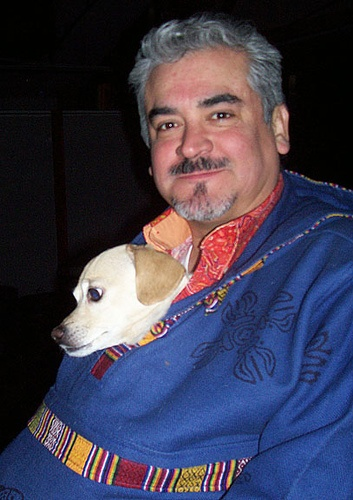

In [ ]:
image_path = "sample.jpg"
image = inference._load_image(image_path)
image_tensor = inference._preprocess_image(image)
image


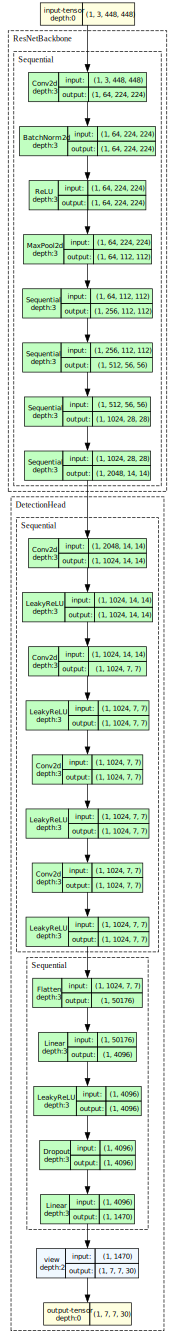

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(
    model,
    input_size=image_tensor.shape,
    expand_nested=True,  # shows submodules
    graph_name="YOLOv1",
)
model_graph.visual_graph

In [ ]:
# run a sample to collect activations and detections
detections = inference.predict(
    image_path=image_path, conf_threshold=0.1, nms_threshold=0.4
)

In [ ]:
# visualize feature maps
display(visualize_activations(activations))

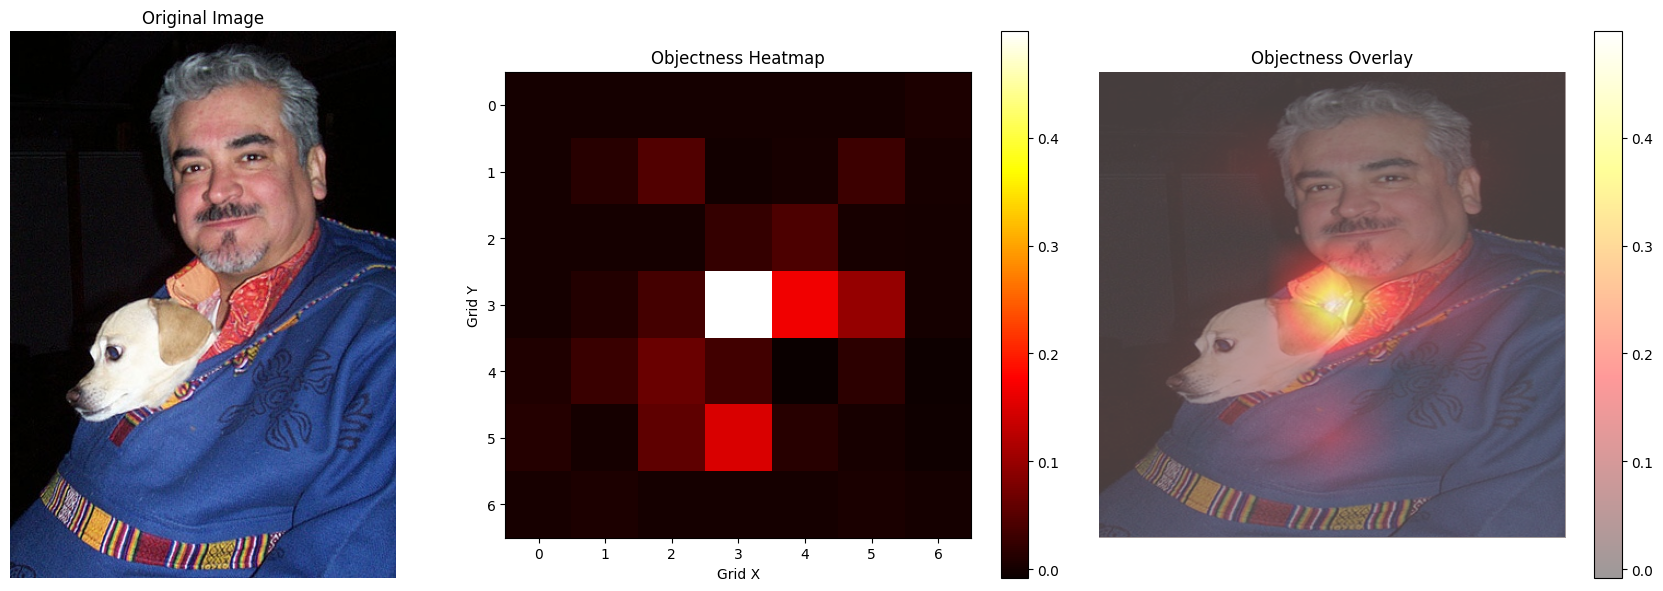

In [ ]:
from yolo.utils.visualization import visualize_objectness_grid

# visualize objectness grid
with torch.no_grad():
    predictions = inference.model(image_tensor)
_ = visualize_objectness_grid(
    image=image,
    predictions=predictions,
)

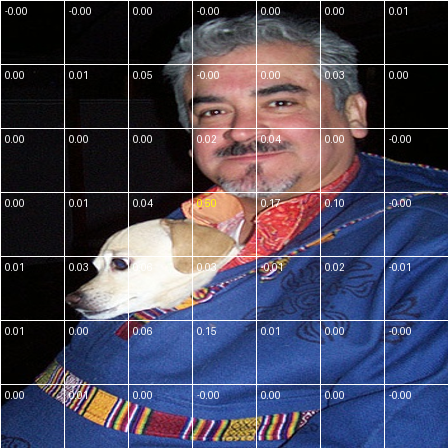

In [ ]:
from yolo.utils.visualization import draw_objectness_grid_on_image

# visualize objectness grid
img_with_grid = draw_objectness_grid_on_image(
    image=image,
    predictions=predictions,
)
display(img_with_grid)

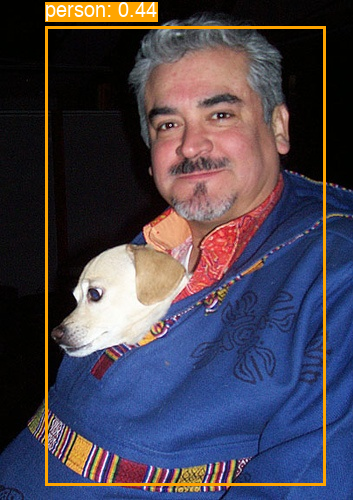

In [ ]:
# draw predictions on image
from yolo.utils.visualization import VOC_CLASSES, draw_detections

img_with_boxes = draw_detections(
    image=image, detections=detections, class_names=VOC_CLASSES, conf_threshold=0.1
)
img_with_boxes